In [3]:
import numpy as np
import pandas as pd
import orodja

### 1) ZAJEM PODATKOV

In [4]:
def glavna(url, html, csv):
    orodja.shrani(url, html)
    orodja.naredi_csv(html, csv)
    print('Uspesen konec')

In [3]:
glavna('https://coinmarketcap.com/currencies/bitcoin/#markets', 'test.txt', 'btc.csv')

Shranjujem https://coinmarketcap.com/currencies/bitcoin/#markets...
shranjeno!
Uspesen konec


Združim take tabele za vse glavne valute (btc, eth, btc cash, xrp, ltc) in odstranim podvojene vnose:
    
DataFrame.drop_duplicates(subset=None, keep='first', inplace=False)

subset = ['borza', 'par', 'volume']

Informacija o ceni se razlikuje (zato uporabim subset, gledam samo prve 3 stolpce), dobro bi bilo spraviti informacije o vseh cenah (za vsako transakcijo imam informacije o obeh valutah iz valutnega para).

#### Alternativno:

Za vsako borzo posebej zajamem podatke o vseh transakcijah (iz coinmarketcap.com) in na podoben način tvorim skupno tabelo. Tak pristop bi bil še bolj uporaben v primeru kombinacije s "side bar plotom".

https://coinmarketcap.com/exchanges/poloniex/

### 2) ANALIZA PODATKOV

valutni par = base currency / quote currency

In [4]:
btc = pd.read_csv('btc.csv')
btc.head()

,borza,par,volume,price
0,Bithumb,BTC/KRW,"$227,854,000",$4321.31
1,Bittrex,NEO/BTC,"$193,455,000",$4173.70
2,Bitfinex,BTC/USD,"$148,679,000",$4257.00
3,OKCoin.cn,BTC/CNY,"$89,803,700",$4288.76
4,GDAX,BTC/USD,"$80,494,900",$4278.71


In [5]:
def preprocessing(df):
    df['volume'] = df['volume'].replace( '[\$,)]','', regex=True )
    df.volume = df.volume.astype(float)
    df['price'] = df['price'].replace( '[\$,)]','', regex=True )
    df.price = df.price.astype(float)
    df['base'], df['quote'] = df['par'].str.split('/', 1).str
    return df

In [6]:
def izberi(sez_valut, sez_borz, data):
    sez_valut = '|'.join(sez_valut)
    sez_borz = '|'.join(sez_borz)
    data['tmpBorze'] = data.borza.str.contains(sez_borz)
    data['tmpValute'] = data.par.str.contains(sez_valut)
    data = data[data.tmpBorze == True]
    data = data[data.tmpValute == True]
    data = data.drop('tmpBorze', axis=1)
    data = data.drop('tmpValute', axis=1)
    data = preprocessing(data)
    return data
    

Tu ignoriram ostale borze (in ostale valute), moram jih še združiti v skupino OTHER (grupiram po valutnih parih in seštejem volume).

In [7]:
valute = ['USD', 'BTC', 'XRP', 'ETH', 'EUR']
valuteStrict = ['BTC/USD', 'USD/BTC', 'BTC/ETH', 'ETH/BTC', 'BTC/XRP', 'XRP/BTC', 'BTC/EUR', 'EUR/BTC']
borze = ['Kraken', 'Bitstamp', 'Poloniex', 'Bitfinex']
#izberi(valute, borze, btc).head()

In [8]:
primer = izberi(valuteStrict, borze, btc)
primer

,borza,par,volume,price,base,quote
2,Bitfinex,BTC/USD,148679000.0,4257.00,BTC,USD
7,Poloniex,ETH/BTC,73736800.0,4266.65,ETH,BTC
11,Kraken,BTC/EUR,59466200.0,4316.18,BTC,EUR
13,Bitstamp,BTC/USD,52725500.0,4256.99,BTC,USD
14,Poloniex,BTC/USDT,46135100.0,4274.15,BTC,USDT
20,Kraken,BTC/USD,35633900.0,4301.00,BTC,USD
28,Kraken,ETH/BTC,17243200.0,4277.56,ETH,BTC
30,Poloniex,XRP/BTC,15541700.0,4296.36,XRP,BTC
31,Bitfinex,ETH/BTC,15401000.0,4272.62,ETH,BTC
42,Bitstamp,BTC/EUR,9326070.0,4292.59,BTC,EUR


In [8]:
#nodes
vozli = list(set(primer.base.tolist() + primer.quote.tolist()))

#### Pseudo koda za zajem podatkov (na vsakih 24h)
opazovane_valute = ['btc', 'eth', 'ltc', 'xrp', ...]

dnevna_tabela = dataFrame

for valuta in opazovane valute:

    valutna_tabela = glavna(url_valuta, ...) #scrapping from coinmarketcap 
    
    dodaj valutna_tabela k dnevna_tabela
    
odstrani podvojene vrstice (katere inforamcije o ceni je smiselno ohraniti?)

izberi(dnevna_valuta, borze, valute) #selection of selected exchanges and currencies

OUTPUT: tabela s prikazanami transakcijami na vseh izbranih borzah, pripravljena na poljubno vizualizacijo
(za primer outputa glej tabelo 'primer' zgoraj)

### 3) VIZUALIZACIJA

#### a) NetworkX library (oz. kakšna druga python knjižnica za graph visualization)

http://networkx.readthedocs.io/en/latest/tutorial.html #dokumentacija

http://networkx.readthedocs.io/en/latest/auto_examples/index.html  #primeri

Lahko bi naredil usmerjen graf. Atributi povezav bi bila imena borz in velikost transakcije, velikost "balončka" bi bil seštevek vhodnih povezav.

https://www.youtube.com/watch?v=6Lauxn9oTt4

2:42:00  kako nastaviti velikost balončkov in debelino povezav glede na izbrane atribute

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

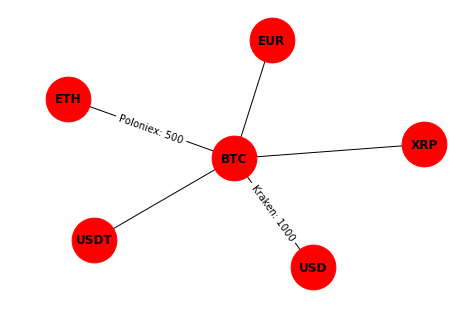

In [36]:
G=nx.from_pandas_dataframe(primer, 'base', 'quote', ['volume', 'price'])
labels = {('USD','BTC'):'Kraken: 1000', ('BTC','ETH'):'Poloniex: 500'}

pos=nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2000)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=10)

plt.show()

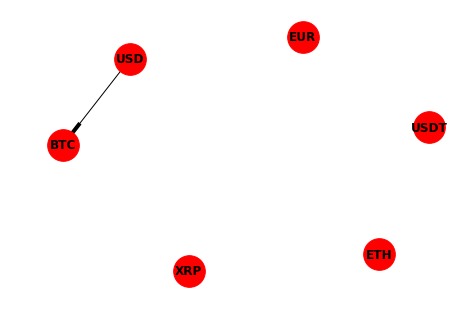

In [41]:
#G = nx.Graph()
DG = nx.DiGraph()
DG.add_nodes_from(vozli)
DG.add_edge('USD', 'BTC')
#DG.add_edge('BTC', 'USD') #problem pri dodajanju "dvojnih" povezav ==> enostavna rešitev, uporabim multi graphs namesto DiGraph
nx.draw(DG, with_labels=True, font_weight='bold', node_size=1000)
plt.draw()

https://stackoverflow.com/questions/20381460/networkx-how-to-show-node-and-edge-attributes-in-a-graph-drawing

Ni dobre podpore za enostaven prikaz atributov povezav (npr. ime borze in velikost transakcije):

"NetworkX provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. In the future, graph visualization functionality may be removed from NetworkX or only available as an add-on package. Proper graph visualization is hard, and we highly recommend that people visualize their graphs with tools dedicated to that task. Notable examples of dedicated and fully-featured graph visualization tools are Cytoscape, Gephi, Graphviz and, for LaTeX typesetting, PGF/TikZ. To use these and other such tools, you should export your NetworkX graph into a format that can be read by those tools. For example, Cytoscape can read the GraphML format, and so,networkx.writegraphml(G)networkx.writegraphml(G) might be an appropriate choice."


Alternative:

- plotly ( https://plot.ly/python/3d-network-graph/ )
- graph-tool ( https://graph-tool.skewed.de/static/doc/index.html ) #slaba podpora za Windows

#### b) Kombinacija "side bar plot" in "grafov"

In [1]:
from IPython.display import Image

https://twitter.com/FollowTheChain

Ob kliku na ime borze se prikaže graf, ki prikazuje dinamiko oz. gibanje med valutami na izbrani borzi v tistem dnevu. V tem primeru je bolj uporaben alternativen način zajetja podatkov (za vsako borzo posebej).
![texte](sidebar.png)

#### c) Uporaba 'R' knjižnic

http://kateto.net/network-visualization

Glej del s časovno animacijo (proti koncu strani, poglavje 7.2).
Koristno tudi poglavje 4.2, govori o "plotting parameters".
![texte](rPrimer.png)

#### d) Ostalo

- Heat maps (network matrix)

- Arc diagrams

In [29]:
def edges(df):
    df = df[['quote', 'base', 'borza', 'volume']]
    return df

#manjka še način za določitev velikosti balončkov
def vertices(df):
    vozli = list(set(df.base.tolist() + df.quote.tolist()))
    vozli = pd.DataFrame(vozli)
    vozli.columns = ['currency']
    # 1 - kriptovaluta, 2 - navadna valuta
    vozli['currencyType'] = np.where((vozli['currency'] == 'USD')|(vozli['currency'] == 'EUR'), 2, 1)
    return vozli

In [36]:
povezave = edges(primer)

In [31]:
vozlisca = vertices(primer)

In [37]:
povezave.to_csv('povezave.csv', sep=',', index=False)
vozlisca.to_csv('vozli.csv', sep=',', index=False)